# 25. Denoising AutoEncoder

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn.init
from torch.autograd import Variable

import torchvision
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import numpy as np
import random
import os

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## 25.1 Preparing SVHN Data

In [3]:
svhn_train = dsets.SVHN(root='data/',
                          split='train',
                          transform=transforms.ToTensor(),
                          download=True)

svhn_test = dsets.SVHN(root='data/',
                         split='test',
                         transform=transforms.ToTensor(),
                         download=True)

Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat


In [4]:
batch_size = 100

train_loader  = torch.utils.data.DataLoader(dataset=svhn_train,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=svhn_test,
                                         batch_size=1,
                                         shuffle=False)

In [5]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

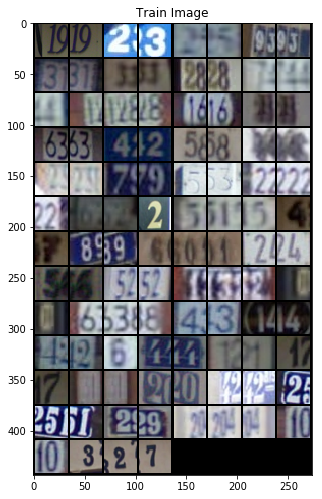

In [6]:
images, labels = iter(train_loader).next()
imshow(torchvision.utils.make_grid(images, normalize=True), "Train Image")

In [7]:
images.shape

torch.Size([100, 3, 32, 32])

## 25.2 Define Model

In [8]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3,16,5),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16,32,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(32),
            nn.Conv2d(32,64,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2) #64*4*4
        )
        
    def forward(self, x):
        z = self.encoder(x)
        
        return z

In [9]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64,32,4,stride=2,padding=1),
#             nn.MaxUnpool2d(2,2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32,16,4,stride=2,padding=1),
#             nn.MaxUnpool2d(2,2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16,3,4,stride=2,padding=1),
            nn.ReLU()
        )
        
    def forward(self, z):
        out = self.decoder(z)
        out = out.view(-1,3,32,32)
        
        return out

In [10]:
E = Encoder().cuda()
D = Decoder().cuda()

## 25.3 Model Training

In [11]:
loss = nn.MSELoss()
optimizer = optim.Adam(list(E.parameters()) + list(D.parameters()), lr=0.001)

In [12]:
num_epochs = 5

In [13]:
for epoch in range(num_epochs):
    
    total_batch = len(svhn_train) // batch_size
    
    for i, (batch_images, batch_labels) in enumerate(train_loader):
        
        X = Variable(batch_images).cuda()
        
        noise = torch.randn(X.size())*0.1
        noise = Variable(noise).cuda()
        
        noise_X = X + noise
        
        pre = D(E(noise_X))
        cost = loss(pre, X)
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print('Epoch [%d/%d], lter [%d/%d] Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, total_batch, cost.data[0]))
    
print("Learning Finished!")

Epoch [1/5], lter [100/732] Loss: 0.0195
Epoch [1/5], lter [200/732] Loss: 0.0114
Epoch [1/5], lter [300/732] Loss: 0.0098
Epoch [1/5], lter [400/732] Loss: 0.0122
Epoch [1/5], lter [500/732] Loss: 0.0080
Epoch [1/5], lter [600/732] Loss: 0.0092
Epoch [1/5], lter [700/732] Loss: 0.0087
Epoch [2/5], lter [100/732] Loss: 0.0075
Epoch [2/5], lter [200/732] Loss: 0.0076
Epoch [2/5], lter [300/732] Loss: 0.0073
Epoch [2/5], lter [400/732] Loss: 0.0093
Epoch [2/5], lter [500/732] Loss: 0.0066
Epoch [2/5], lter [600/732] Loss: 0.0080
Epoch [2/5], lter [700/732] Loss: 0.0069
Epoch [3/5], lter [100/732] Loss: 0.0065
Epoch [3/5], lter [200/732] Loss: 0.0068
Epoch [3/5], lter [300/732] Loss: 0.0064
Epoch [3/5], lter [400/732] Loss: 0.0085
Epoch [3/5], lter [500/732] Loss: 0.0062
Epoch [3/5], lter [600/732] Loss: 0.0074
Epoch [3/5], lter [700/732] Loss: 0.0063
Epoch [4/5], lter [100/732] Loss: 0.0059
Epoch [4/5], lter [200/732] Loss: 0.0061
Epoch [4/5], lter [300/732] Loss: 0.0058
Epoch [4/5], lte

## 25.4 Test Model

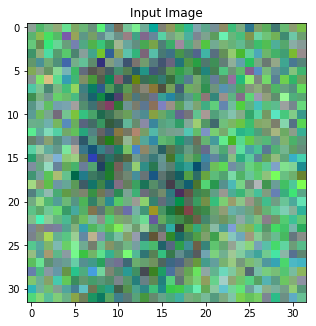

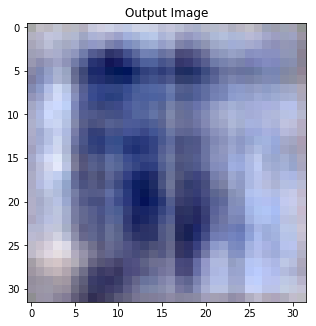

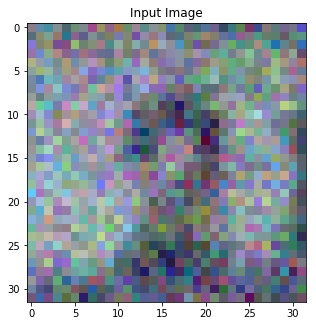

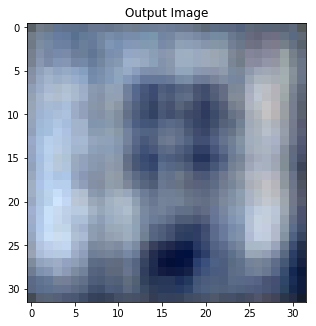

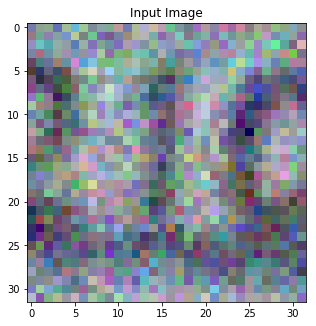

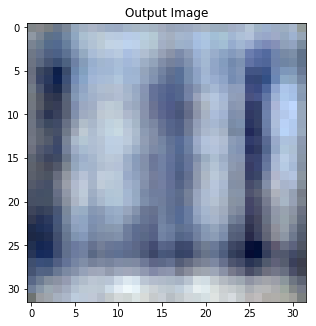

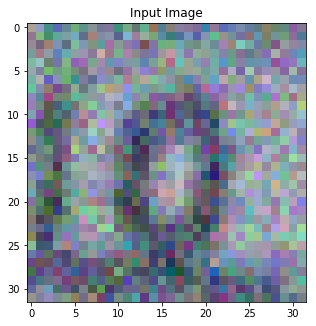

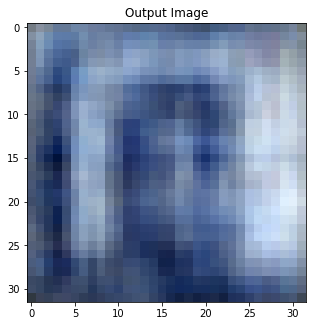

In [14]:
E.eval()
D.eval()

for n, (images, labels) in enumerate(test_loader):
    
    images = Variable(images).cuda()
    
    noise = torch.randn(images.size())*0.1
    noise = Variable(noise).cuda()
    
    noise_images = images + noise
    
    imshow(torchvision.utils.make_grid(noise_images.data.cpu(), normalize=True), "Input Image")
    
    noise_images = noise_images.view(-1, 3, 32, 32)
    
    outputs = D(E(noise_images))
    outputs = outputs.view(-1, 3, 32, 32)
    
    imshow(torchvision.utils.make_grid(outputs.data.cpu(), normalize=True), "Output Image")
    
    if n > 2 : break